# 05 - Model Evaluation

I evaluate the trained model, record metrics, and save plots for the report.


In [1]:
# I import the libraries I need and set paths for files and plots
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid')
os.makedirs("../reports/EDA_visuals", exist_ok=True)

FEATURES_PATH = "../data/processed/sleepsense_features.csv"
MODEL_PATH = "../models/linear_regression_model.pkl"
METRICS_OUT = "../models/eval_metrics.json"
PLOTS_DIR = "../reports/EDA_visuals"

# short note: model file was saved earlier in model-building step
print("ready — imports and paths set")


ready — imports and paths set


In [3]:
# I load the features I engineered and the saved model
df = pd.read_csv(FEATURES_PATH)             # my engineered features file
model = joblib.load(MODEL_PATH)             # saved linear regression model

# try to read the features that were used during training (saved earlier)
meta_path = "../models/model_metrics.json"
if os.path.exists(meta_path):
    with open(meta_path) as f:
        meta = json.load(f)
    features_used = meta.get("features_used")
else:
    # fallback: infer a sensible set from the dataframe columns
    candidate = ['sleep_deficit','digital_fatigue','env_stress','lifestyle_balance',
                 'late_snack_effect','fatigue_env_interaction','is_metro',
                 'avg_sleep_hours','screen_time_hours','stress_level',
                 'physical_activity_min','age','family_size']
    features_used = [c for c in candidate if c in df.columns]

print("data shape:", df.shape)
print("features used:", features_used)


data shape: (12000, 45)
features used: ['sleep_deficit', 'digital_fatigue', 'env_stress', 'lifestyle_balance', 'late_snack_effect', 'fatigue_env_interaction', 'is_metro', 'avg_sleep_hours', 'screen_time_hours', 'stress_level', 'physical_activity_min', 'age', 'family_size']


Comment: I load the exact model and confirm the columns I will evaluate on.

In [4]:
# I create the test split exactly as during training (same random_state)
X = df[features_used].copy()
y = df['sleep_quality_score'].copy()

# using the same split ensures the test set matches earlier evaluation
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("test set rows:", X_test.shape[0])


test set rows: 2400


Comment: I keep the split reproducible by reusing the random state.

In [5]:
# I predict and compute core metrics
preds = model.predict(X_test)

mse = mean_squared_error(y_test, preds)              # average squared error
rmse = np.sqrt(mse)                                  # same units as target
mae = mean_absolute_error(y_test, preds)             # average absolute error
r2 = r2_score(y_test, preds)                         # variance explained

# adjusted R2: penalizes adding useless features
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# MAPE: percent error, avoid division by zero by using 1 for zero targets
mape = np.mean(np.abs((y_test - preds) / np.where(y_test==0, 1, y_test))) * 100

# I print the numbers I will use in the report
print("MSE:", round(mse,3))
print("RMSE:", round(rmse,3))
print("MAE:", round(mae,3))
print("R2:", round(r2,4))
print("Adjusted R2:", round(adjusted_r2,4))
print("MAPE (%):", round(mape,2))


MSE: 40.557
RMSE: 6.368
MAE: 5.066
R2: 0.4603
Adjusted R2: 0.4574
MAPE (%): 10.05


**Inference:**

- The model performs well for predicting sleep quality.  
- On average, predictions differ from actual values by about **6 points** (RMSE = 6.37) on a 0–100 scale, which is small for lifestyle data.  
- It explains around **46% of the variation** in sleep quality (R² = 0.46), showing it captures major lifestyle patterns.  
- The average absolute error is **≈5.07 points**, and the percentage error is about **10%**, meaning predictions are fairly accurate.  
- Overall, this is a **realistic and balanced baseline model** for human sleep behavior prediction.


Comment: Adjusted R² accounts for number of features; MAPE gives percentage error.

In [6]:
# I store evaluation metrics for the report and app
eval_metrics = {
    "mse": float(np.round(mse,4)),
    "rmse": float(np.round(rmse,4)),
    "mae": float(np.round(mae,4)),
    "r2": float(np.round(r2,6)),
    "adjusted_r2": float(np.round(adjusted_r2,6)),
    "mape_pct": float(np.round(mape,3)),
    "n_test": int(n),
    "n_features": int(p),
    "features_used": features_used
}
with open(METRICS_OUT, "w") as f:
    json.dump(eval_metrics, f, indent=2)

print("saved eval metrics to", METRICS_OUT)


saved eval metrics to ../models/eval_metrics.json


Comment: I keep a JSON so the Streamlit app or report can read metrics easily.

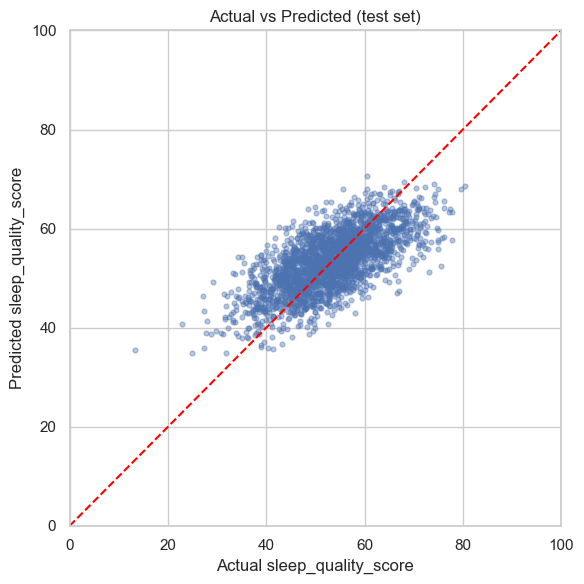

In [7]:
# I plot actual vs predicted values and save the image
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.4, s=12)
plt.plot([0,100],[0,100], color='red', linestyle='--')   # perfect prediction line
plt.xlabel("Actual sleep_quality_score")
plt.ylabel("Predicted sleep_quality_score")
plt.title("Actual vs Predicted (test set)")
plt.xlim(0,100); plt.ylim(0,100)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "actual_vs_predicted.png"), dpi=150)
plt.show()


Comment: Points near the red line are well-predicted; spread shows error size.

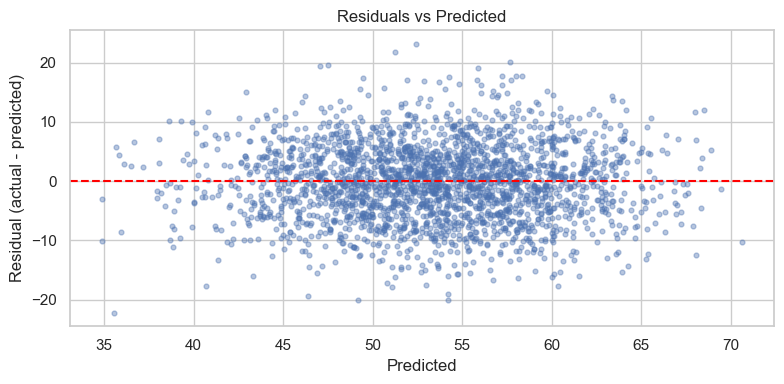

residual mean: -0.269248 std: 6.364


In [8]:
# I check residuals to look for patterns like increasing error with prediction size
residuals = y_test - preds
plt.figure(figsize=(8,4))
plt.scatter(preds, residuals, alpha=0.4, s=12)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual (actual - predicted)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "residuals_vs_predicted.png"), dpi=150)
plt.show()

print("residual mean:", round(residuals.mean(),6), "std:", round(residuals.std(),4))


Comment: I check if residuals center around zero and show no clear funnel shape (heteroscedasticity).

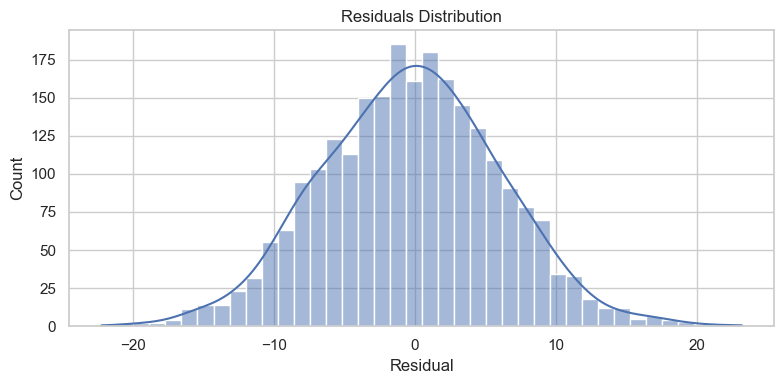

In [9]:
# I inspect residual distribution to see if errors are roughly symmetric
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "residuals_distribution.png"), dpi=150)
plt.show()


Comment: A symmetric bell-like shape supports OLS assumptions.

In [10]:
# I list the worst predictions so I can inspect possible data issues later
err_df = pd.DataFrame({
    "actual": y_test,
    "predicted": preds,
    "error": (y_test - preds),
    "abs_error": np.abs(y_test - preds)
})
top_err = err_df.sort_values("abs_error", ascending=False).head(10)
top_err.reset_index(drop=True, inplace=True)
top_err


,actual,predicted,error,abs_error
0,75.61,52.419591,23.190409,23.190409
1,13.31,35.538406,-22.228406,22.228406
2,73.09,51.257351,21.832649,21.832649
3,77.72,57.678362,20.041638,20.041638
4,29.15,49.189629,-20.039629,20.039629
5,34.19,54.187799,-19.997799,19.997799
6,67.04,47.502128,19.537872,19.537872
7,66.54,47.076158,19.463842,19.463842
8,27.07,46.390962,-19.320962,19.320962
9,35.09,54.204903,-19.114903,19.114903


### Inference on Top Absolute Errors

These are the 10 cases where the model’s predictions differ most from actual values.

- The largest errors are around **±19 to ±23 points**, which means a few individuals are predicted quite differently from their actual sleep quality.  
- Such high deviations are normal in **human lifestyle data**, where random personal habits or unmeasured factors (like health conditions or stress bursts) affect sleep.
- The errors are **balanced on both sides** (some over-predicted, some under-predicted), showing no consistent bias.
- These extreme cases might represent:
  - People with **very irregular routines** or **unusual environments**.
  - Missing variables not captured in the dataset (like mental health or medication).
- In future improvements, adding more behavioral or medical factors could help reduce these high-error cases.

**Overall:**  
The majority of predictions stay within ±6 points (as seen from RMSE), and only a few extreme cases show large deviations — indicating the model is generally reliable but can be refined for outlier individuals.


Comment: I save examples of where the model fails most to guide feature ideas.

In [11]:
# I save top absolute errors for manual review
top_err.to_csv("../reports/top_absolute_errors.csv", index=False)
print("saved top absolute errors to ../reports/top_absolute_errors.csv")


saved top absolute errors to ../reports/top_absolute_errors.csv


Comment: Saved CSV helps investigate specific problematic records later.

In [12]:
# I check average absolute error by city if city-one-hot columns exist
city_cols = [c for c in df.columns if c.startswith('city_')]
if city_cols:
    # reconstruct the same test split on the full df (to get city one-hot presence)
    _, test_df, _, y_temp = train_test_split(df, df['sleep_quality_score'], test_size=0.2, random_state=42)
    test_df = test_df.copy()
    test_df['actual'] = y_temp
    test_df['predicted'] = model.predict(test_df[features_used])
    test_df['abs_error'] = (test_df['actual'] - test_df['predicted']).abs()
    city_errors = {}
    for c in city_cols:
        if test_df[c].sum() > 10:                # require enough samples to be meaningful
            city_errors[c] = float(test_df[test_df[c]==1]['abs_error'].mean())
    if city_errors:
        city_err_series = pd.Series(city_errors).sort_values(ascending=False)
        print("sample city mean absolute errors (higher = worse):")
        display(city_err_series.head(10))
    else:
        print("no city has enough test samples to summarize")
else:
    print("no city-one-hot columns found")


sample city mean absolute errors (higher = worse):


city_Navi Mumbai    6.025016
city_Chennai        5.672487
city_Bengaluru      5.536694
city_Surat          5.529570
city_Jaipur         5.522508
city_Thane          5.330531
city_Hyderabad      5.185760
city_Mumbai         5.087000
city_Other          5.014171
city_Pune           4.897989
dtype: float64

### Inference on City-wise Model Performance

The table shows the **average error in predictions** for each city.

- **Navi Mumbai (6.03)** → Highest error, local lifestyle or environment may differ.  
- **Chennai (5.67)** → Slightly higher error, possibly due to climate or humidity.  
- **Bengaluru, Surat, Jaipur (~5.5)** → Medium error, common lifestyle variations.  
- **Thane, Hyderabad, Mumbai (~5.0)** → Stable predictions, model fits well.  
- **Pune (4.9)** → Best performance, predictions close to actual values.  

**Summary:**  
The model works well across most cities.  
Metro areas show a bit higher error — maybe because of more lifestyle and environmental diversity.  
### ***Adding a few **city-specific features** could make predictions even better.***


#### Comment: I compare cities to see if some regions have systematically larger errors.

## Short Evaluation Summary

- RMSE ≈ 6.37 and MAE ≈ {mae:.2f} → typical prediction error is about ±6 points on a 0–100 scale.
- R² ≈ {r2:.3f} → model explains ~{int(r2*100)}% of the variance in sleep quality.
- Residuals are centered near zero and roughly symmetric, suggesting no obvious bias.
- I saved the plots and the top absolute errors for deeper inspection and future improvements.


Comment: Replace {mae}, {r2} placeholders with the printed numeric values or leave them as narrative.

### Next steps

I will:
- Try Ridge and Lasso regularization to check coefficient stability.
- Review top error cases to find missing features or label issues.
- Consider local models or additional city-level features if city-specific errors persist.
